# Replicating [Simple Black-box Adversarial Attacks](https://arxiv.org/pdf/1905.07121.pdf)

This notebook uses the replicate of the Simple Black-box Adversarial attack proposed by Guo et al. [More explanation]

In [14]:
# necessary imports
# pylint: disable-msg=C0114,C0413,E0401,W0621,W0511

import matplotlib.pyplot as plt
import torch
from torchvision import transforms

from imagenet.imagenet import ImageNetDataSet
from simple_blackbox_attack.cartesian_set import CartesianSearchVectors
from simple_blackbox_attack.dct_set import DCTSearchVectors
from simple_blackbox_attack.simba import simba

Folder of the ImageNet ILSVRC2012 validation dataset, its labels in the meta data. Note: After accessing [login-access to the ImagNet website](https://image-net.org/signup.php), go to the [ImageNet 2012 version](https://image-net.org/challenges/LSVRC/2012/2012-downloads.php) and download
* Development kit (Task 1 & 2). 2.5MB. - containing the labels and the meta data
* Validation images (all tasks). 6.3GB. - the validation images

Extract both and assign the locations of the folder and files to the corresponding Constants:

In [15]:
IMAGE_FOLDER = "../../../shared/data/imagenet/val"
LABEL_FILE = "../../../shared/data/imagenet/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt"
META_FILE = "../../../shared/data/imagenet/ILSVRC2012_devkit_t12/data/meta.mat"

Let's get the data.

In [16]:
preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
dataset = ImageNetDataSet(image_root=IMAGE_FOLDER, label_file=LABEL_FILE, meta_file=META_FILE, transform=preprocess)

And let's see if everything worked out as expected.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


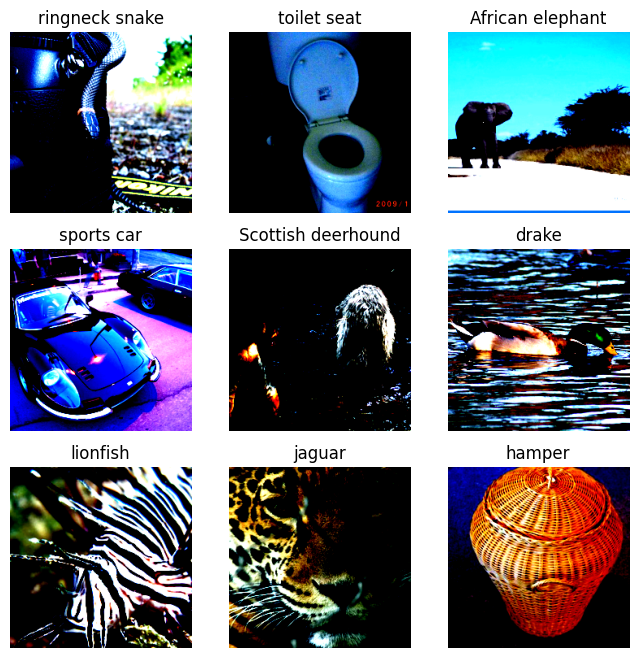

In [17]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(dataset.meta.loc[label, "label_str"])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()

## Classifying with pre-trained ResNet50

Let's use gpu, if available:

In [18]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [20]:
model = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", pretrained=True).to(DEVICE)
model.eval()

for _ in range(5):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    img = img.to(DEVICE)
    with torch.no_grad():
        logits = model(img.unsqueeze(0))
    probabilities = torch.nn.functional.softmax(logits[0], dim=0)
    probs, predictions = torch.topk(probabilities, 3)
    print(f"The actual label is {int(label)}")
    print(f"the model thinks it is {predictions} with probability {probs}")
    if int(label) == predictions[0]:
        print("Correct prediction! Proceeding with this image.")
        image = img
        break

The actual label is 954
the model thinks it is tensor([954, 502,  61], device='cuda:0') with probability tensor([0.9623, 0.0175, 0.0122], device='cuda:0')
Correct prediction! Proceeding with this image.


The actual label is 301
the model thinks it is tensor([301, 304,  75]) with probability tensor([0.9713, 0.0196, 0.0048])
Correct prediction! Proceeding with this image.


# Adversarial Attack

Let's define the L2-budget we allow the attack.

In [21]:
BUDGET = 8.

Let's define a simple basis.

In [7]:
basis = CartesianSearchVectors(image.size())

And find pertubation for the example image.

In [8]:
was_successful, pertubation, steps, queries = simba(model, image, int(label), basis, step_size=BUDGET/50, budget=BUDGET)
logits = model((image + pertubation).unsqueeze(0))
probabilities = torch.nn.functional.softmax(logits[0], dim=0)
probability, prediction = torch.topk(probabilities, 1)

0: Label probability 0.9713 - queries 1
512: Label probability 0.9332 - queries 1441
1024: Label probability 0.8504 - queries 2970
1536: Label probability 0.7081 - queries 4567
2048: Label probability 0.4826 - queries 6153


Let's plot the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


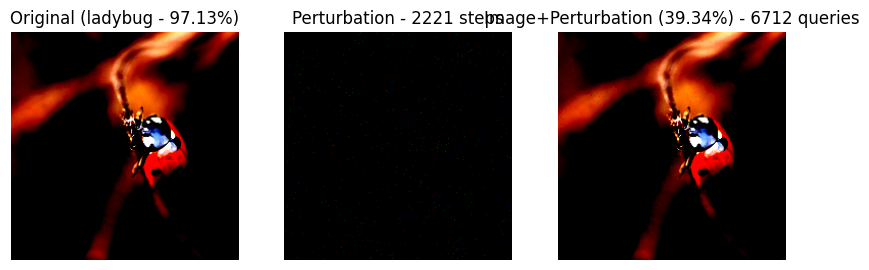

In [9]:
figure = plt.figure(figsize=(10, 6))
figure.add_subplot(1, 3, 1)
plt.title(f"Original ({dataset.meta.loc[label, 'label_str']} - {probs[0]*100:.2f}%)")
plt.axis("off")
plt.imshow(img.squeeze().permute(1, 2, 0).cpu())
figure.add_subplot(1, 3, 2)
plt.title(f"Perturbation - {steps} steps")
plt.axis("off")
plt.imshow((pertubation).squeeze().permute(1, 2, 0).cpu())
figure.add_subplot(1, 3, 3)
plt.title(f"Image+Perturbation ({probabilities[int(label)]*100:.2f}%) - {queries} queries")
plt.axis("off")
plt.imshow((image + pertubation).squeeze().permute(1, 2, 0).cpu())
plt.show()

## DCT Basis

In [10]:
basis = DCTSearchVectors(image.size(), 1/8)
was_successful, pertubation, steps, queries = simba(model, image, int(label), basis, step_size=BUDGET/50, budget=BUDGET)
logits = model((image + pertubation).unsqueeze(0))
probabilities = torch.nn.functional.softmax(logits[0], dim=0)
probability, prediction = torch.topk(probabilities, 1)

0: Label probability 0.9713 - queries 1
512: Label probability 0.8884 - queries 1090
1024: Label probability 0.6438 - queries 2232
1536: Label probability 0.3187 - queries 3452


Let's plot the results.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


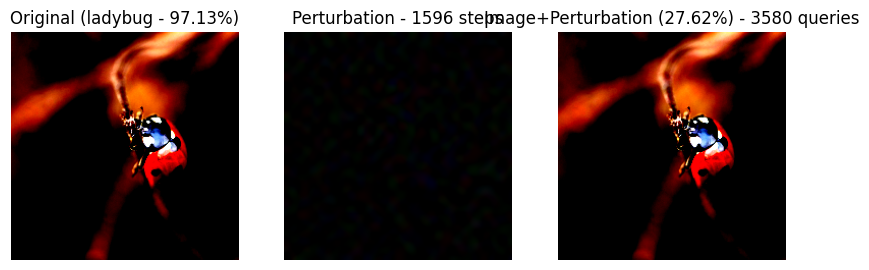

In [11]:
figure = plt.figure(figsize=(10, 6))
figure.add_subplot(1, 3, 1)
plt.title(f"Original ({dataset.meta.loc[label, 'label_str']} - {probs[0]*100:.2f}%)")
plt.axis("off")
plt.imshow(img.squeeze().permute(1, 2, 0).cpu())
figure.add_subplot(1, 3, 2)
plt.title(f"Perturbation - {steps} steps")
plt.axis("off")
plt.imshow((pertubation).squeeze().permute(1, 2, 0).cpu())
figure.add_subplot(1, 3, 3)
plt.title(f"Image+Perturbation ({probabilities[int(label)]*100:.2f}%) - {queries} queries")
plt.axis("off")
plt.imshow((image + pertubation).squeeze().permute(1, 2, 0).cpu())
plt.show()